## Imports

In [1]:
# utils
import os
import sys
from pathlib import Path

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

import matplotlib.lines as mlines
# viz
import matplotlib.pyplot as plt
# basics
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# metrics
from utils import config
from utils.reader import read_file_yaml

np.random.seed(0)

## Parameters

In [2]:
path_root = PROJECT_DIR / "results"

path_conf = PROJECT_DIR / "conf"
file_path_parameters = path_conf / "parameters.yml"
path_outputs = PROJECT_DIR / "outputs"

params = read_file_yaml(file_path_parameters)


if not os.path.exists(path_outputs):
    os.makedirs(path_outputs)

file_path_simulation_plot = path_outputs / params["outputs"]["simulation_random"]["filepath"]

file_path_plot_i_dataset = path_outputs / params["outputs"]["simulation_random"]["data_filepath"]
n_random = np.sort([int(i.replace("random_n", "")) for i in os.listdir(path_root) if ".placehold" not in i])[:44]
path_random = ["random_n" + str(i) for i in n_random]
path_results = [path_root / i for i in path_random]

ext_type = params["outputs"]["extension_type"]
ext_local_img = params["outputs"]["extension_local_img"]
ext_best_img = params["outputs"]["extension_best_img"]

In [3]:
under_line = "\n{}\n"
title_part_n2 = "PROJECT_DIR: [ {} ]".format(PROJECT_DIR)
title_part_n3 = under_line.format("".join(["-"] * len(title_part_n2)))
title_part_n1 = under_line.format("".join(["-"] * len(title_part_n2)))
print(title_part_n1 + title_part_n2 + title_part_n3)


-----------------------------------------------------------------------
PROJECT_DIR: [ /home/manuel/Documents/projects/aaai-claire-clustering ]
-----------------------------------------------------------------------



## Read

In [4]:
parameters = read_file_yaml(file_path_parameters)

In [5]:
init = 1
metrics = {}
for name, url in zip(path_random, path_results):
    metrics[name] = {}
    for dataset in os.listdir(url):
        metrics[name][dataset] = pd.read_csv(url / Path(dataset) / "metrics" / Path("metrics" + ext_type), index_col=0)

## Concat all results

In [6]:
data = metrics[f"random_n{init}"]["aniso"].T.filter(regex="^(?!.*random_model)").T[["abilities"]].reset_index()

data.rename(columns={"abilities": f"n{init}_aniso", "index": "model"}, inplace=True)


for random_n, content_n in metrics.items():
    for name, content_dataset in content_n.items():
        if (random_n == f"random_n{init}") and (name == "aniso"):
            continue
        tmp = content_dataset.T.filter(regex="^(?!.*random_model)").T[["abilities"]].reset_index()

        tmp.rename(
            columns={"abilities": "n{}_{}".format(random_n.replace("random_n", ""), name), "index": "model"},
            inplace=True,
        )

        data = data.merge(tmp, on="model", how="outer")

data.set_index("model", inplace=True)

In [7]:
datasets = {}
for i in config.file_names:
    datasets[i] = data.filter(regex=r"{}".format(i))
    datasets[i].columns = datasets[i].columns.str.replace("_" + i, "")
    datasets[i] = datasets[i][
        [col.replace("random_", "") for col in path_random if col.replace("random_", "") in datasets[i].columns]
    ]

## Plots

In [8]:
models = list(config.models.keys()) + ["average_model", "optimal_clustering"]
gray_scale = [str(i / len(models)) for i in range(1, len(models))]
colors = plt.cm.coolwarm(np.linspace(0, 1, len(models)))
markers = list(mlines.Line2D.markers.keys())

_params = {
    _model: {"color": colors[_idx], "marker": markers[_idx], "linestyle": "--"} for _idx, _model in enumerate(models)
}
handler_lines = [
    Line2D([], [], color=param["color"], linestyle=param["linestyle"], marker=param["marker"])
    for param in _params.values()
]

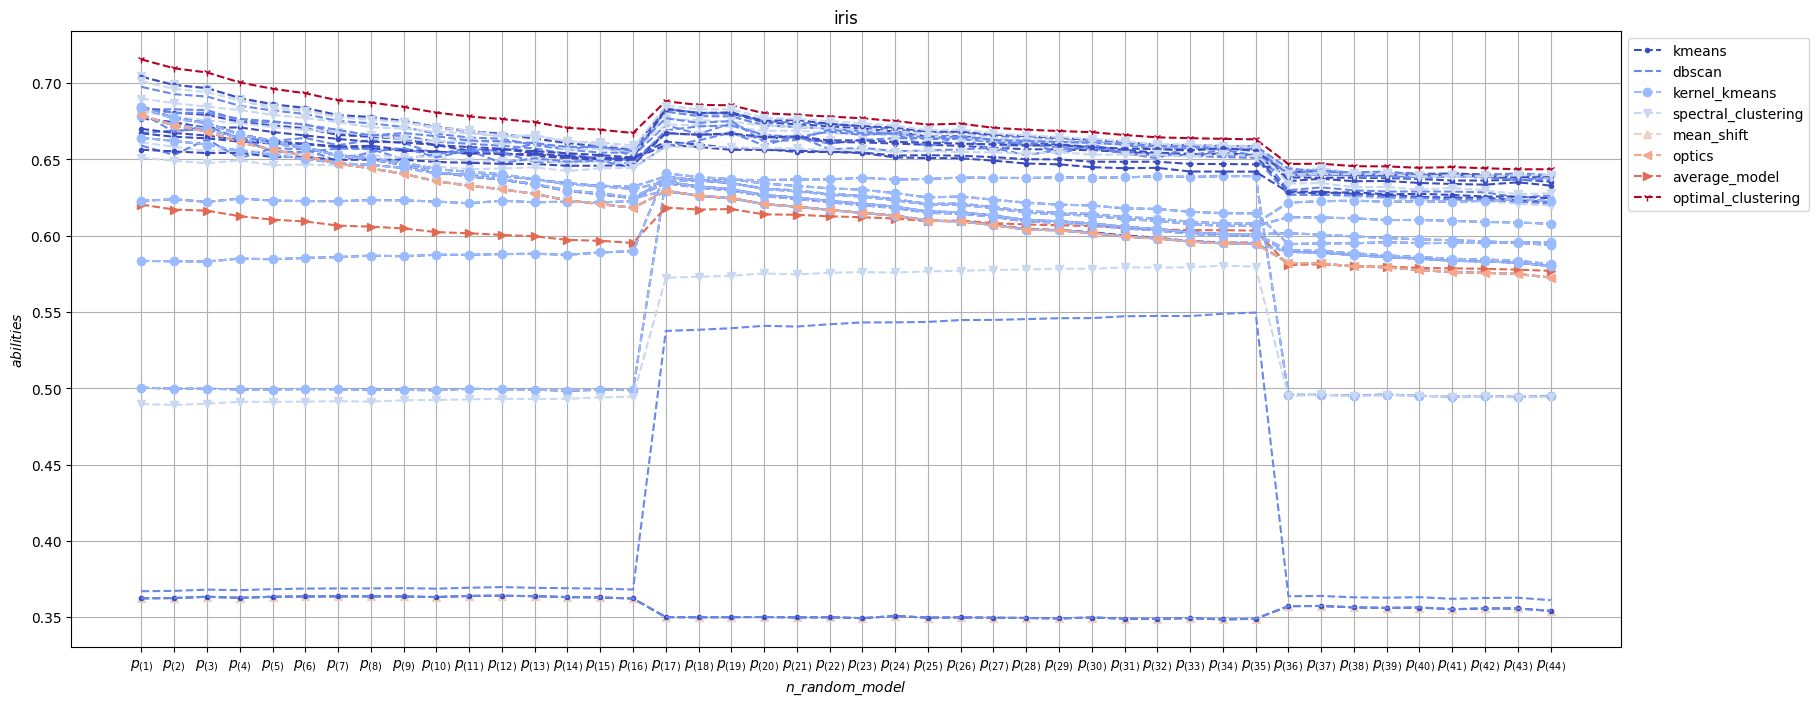

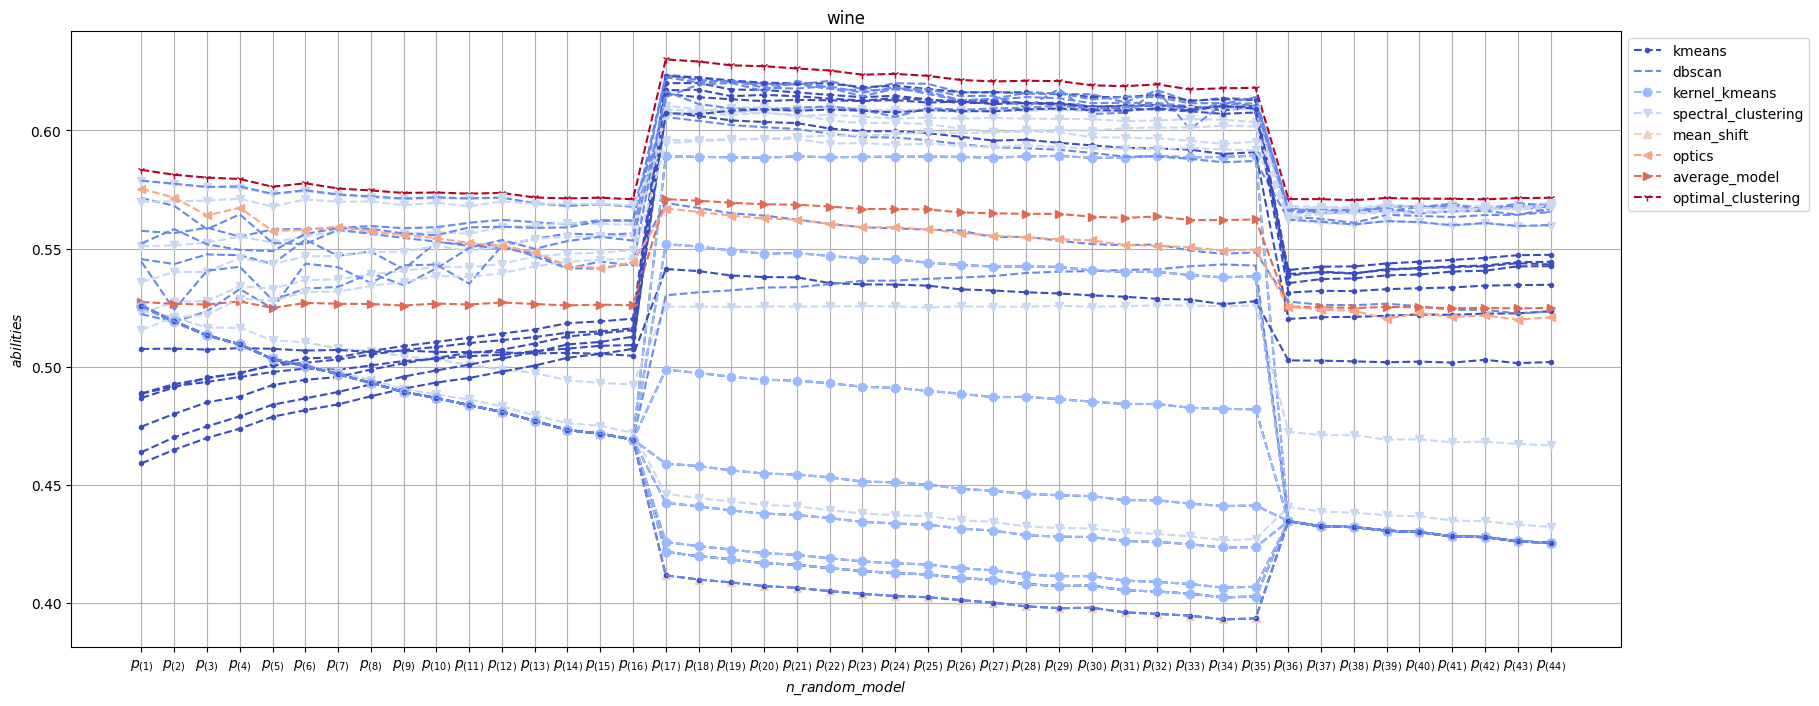

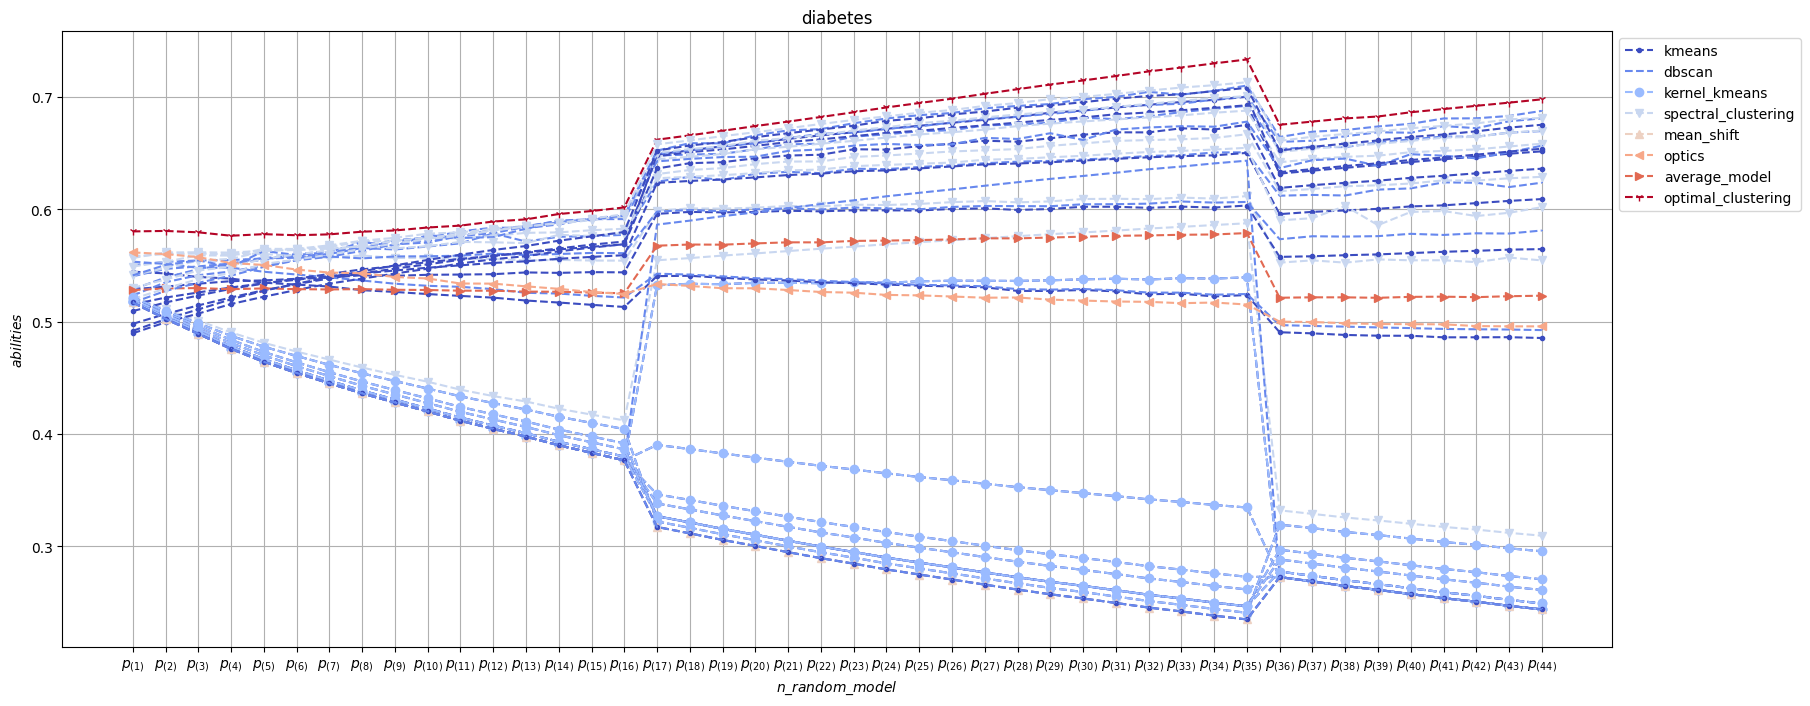

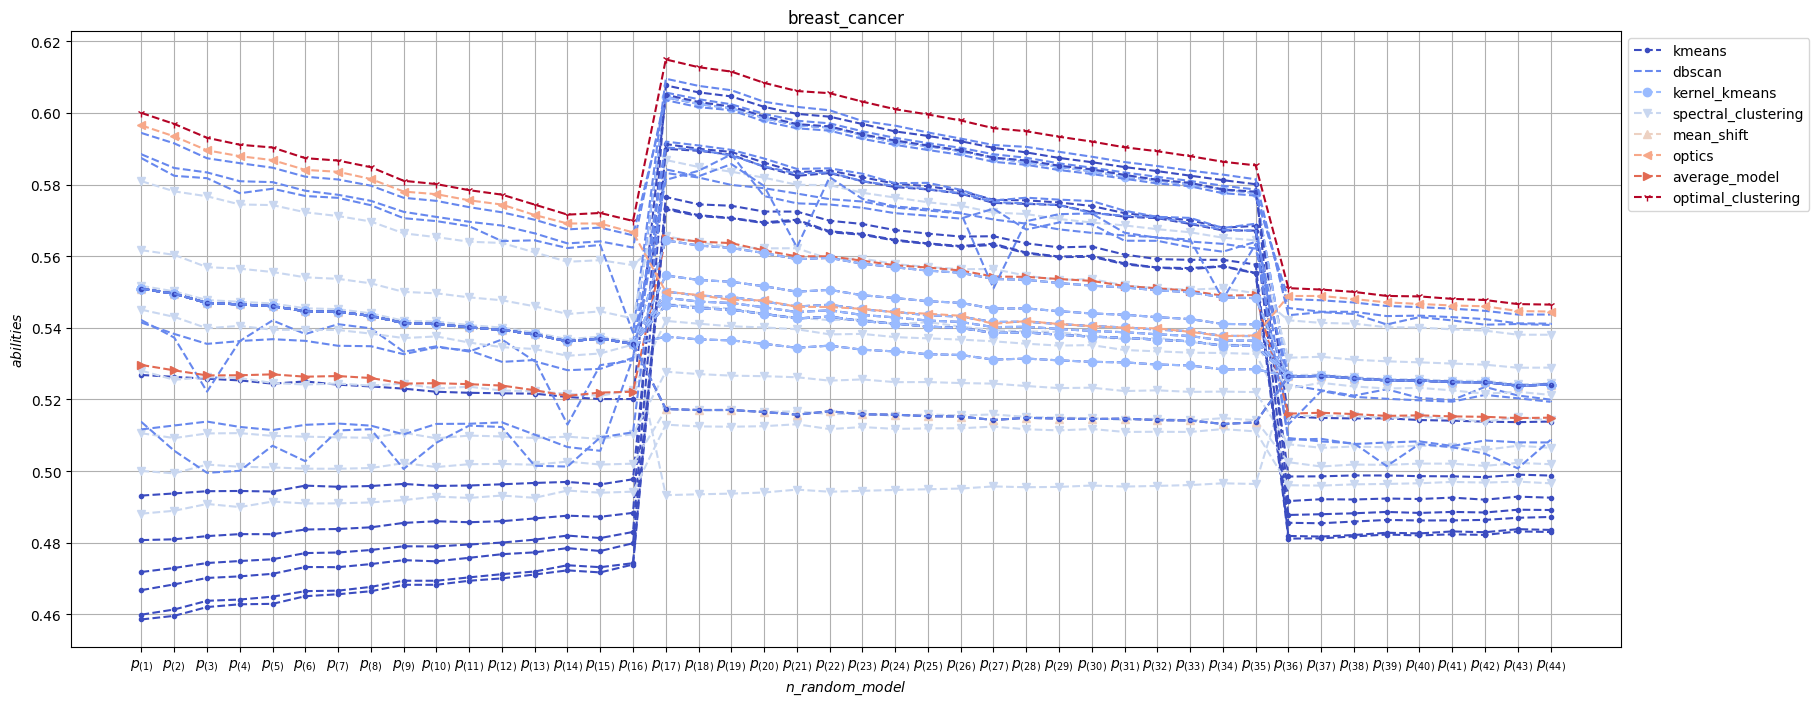

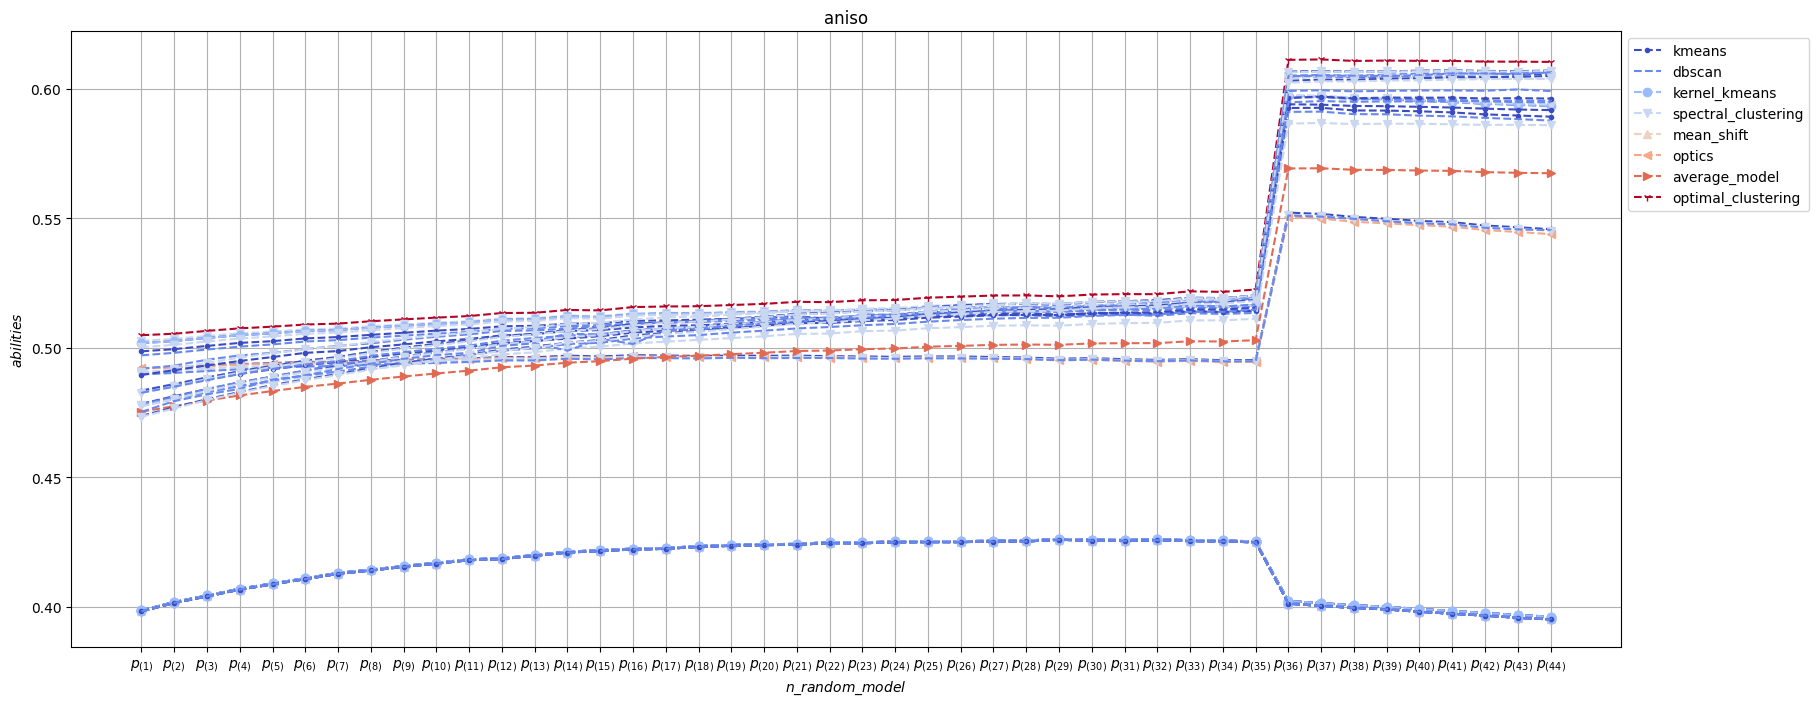

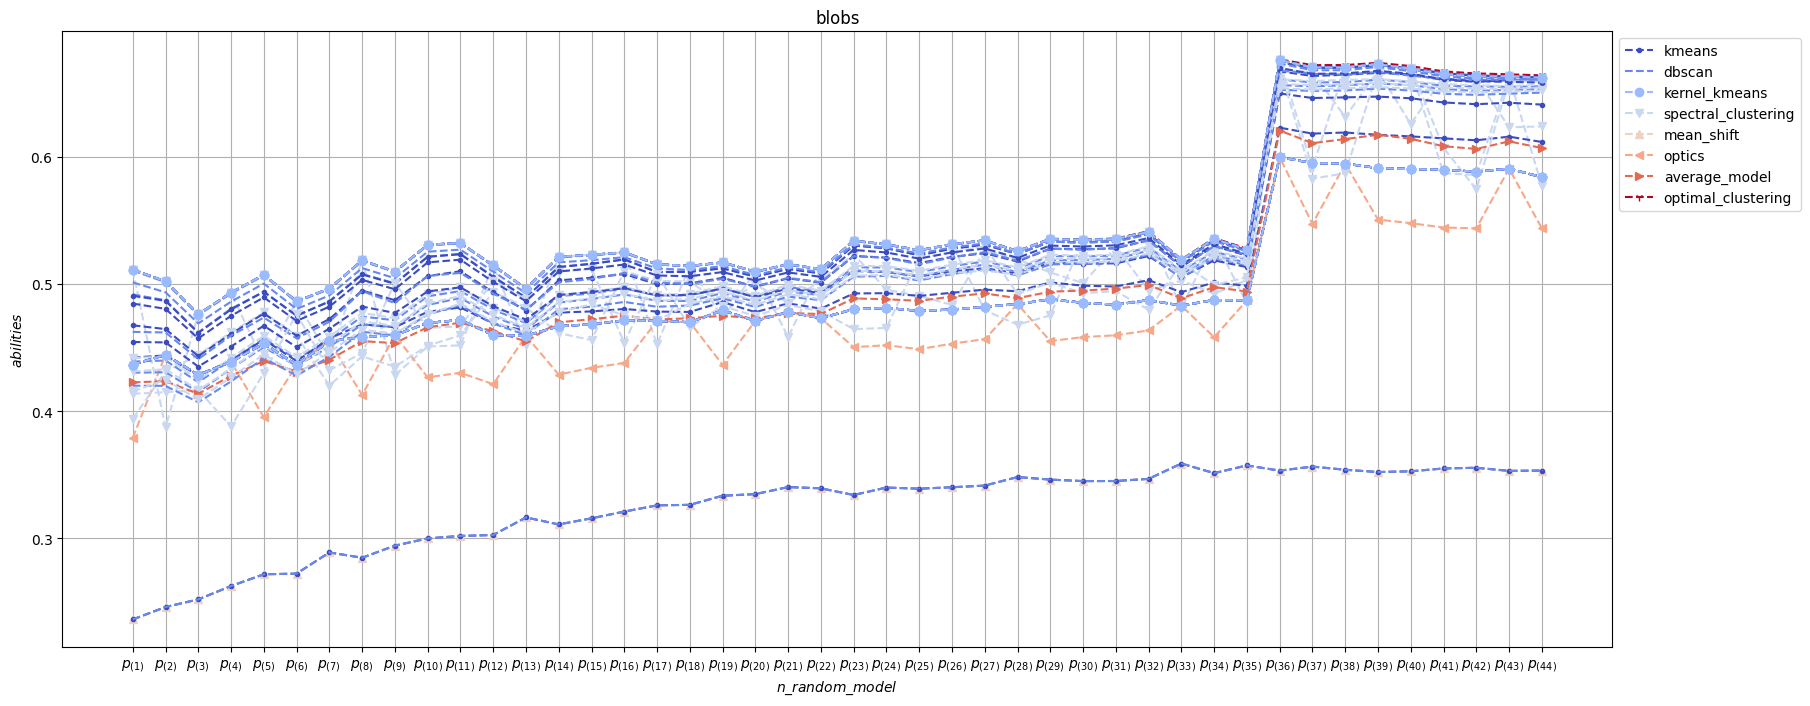

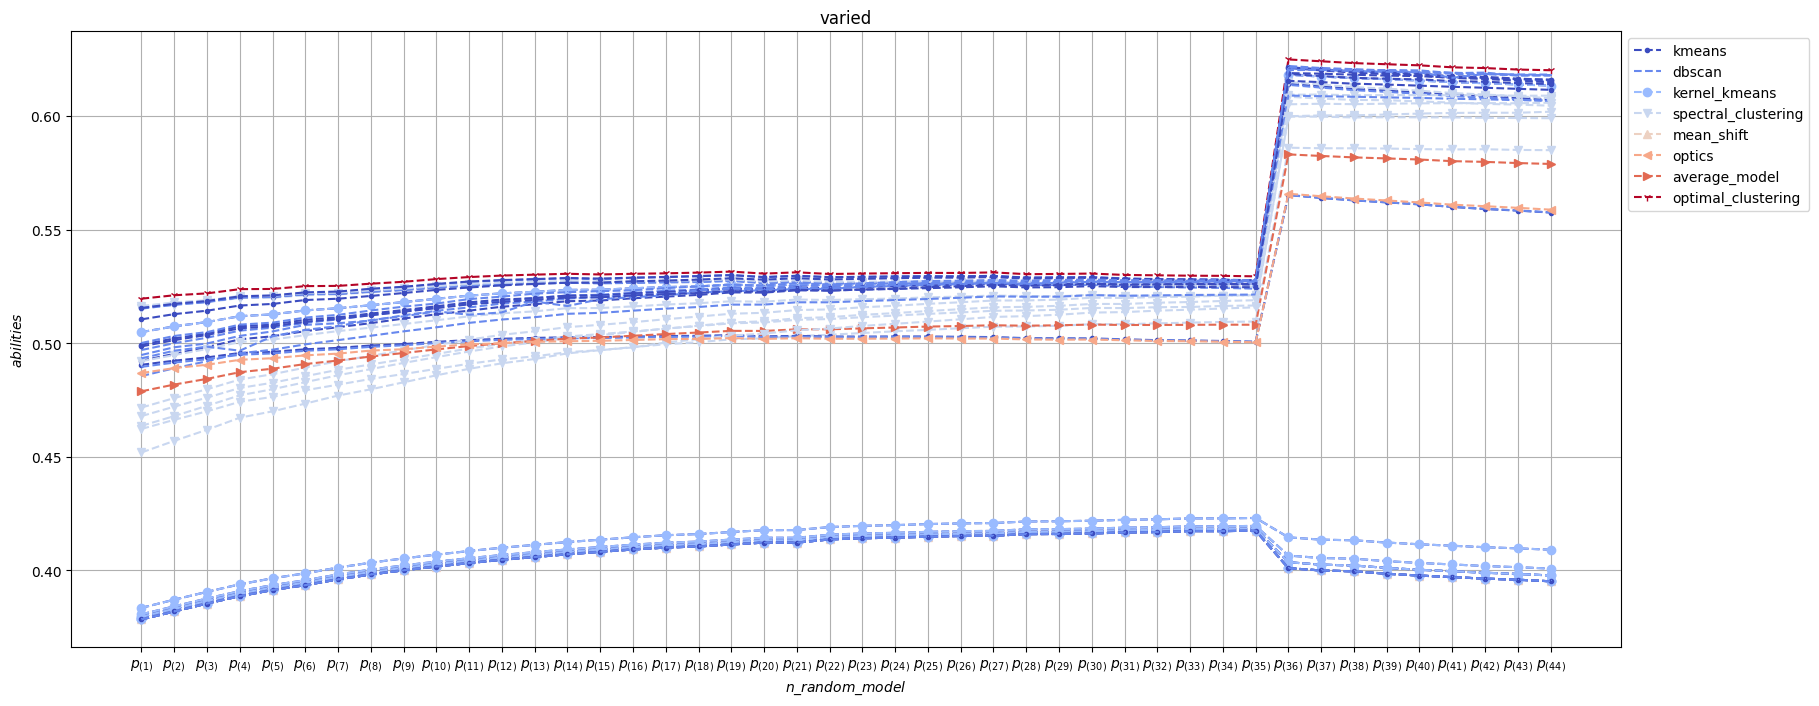

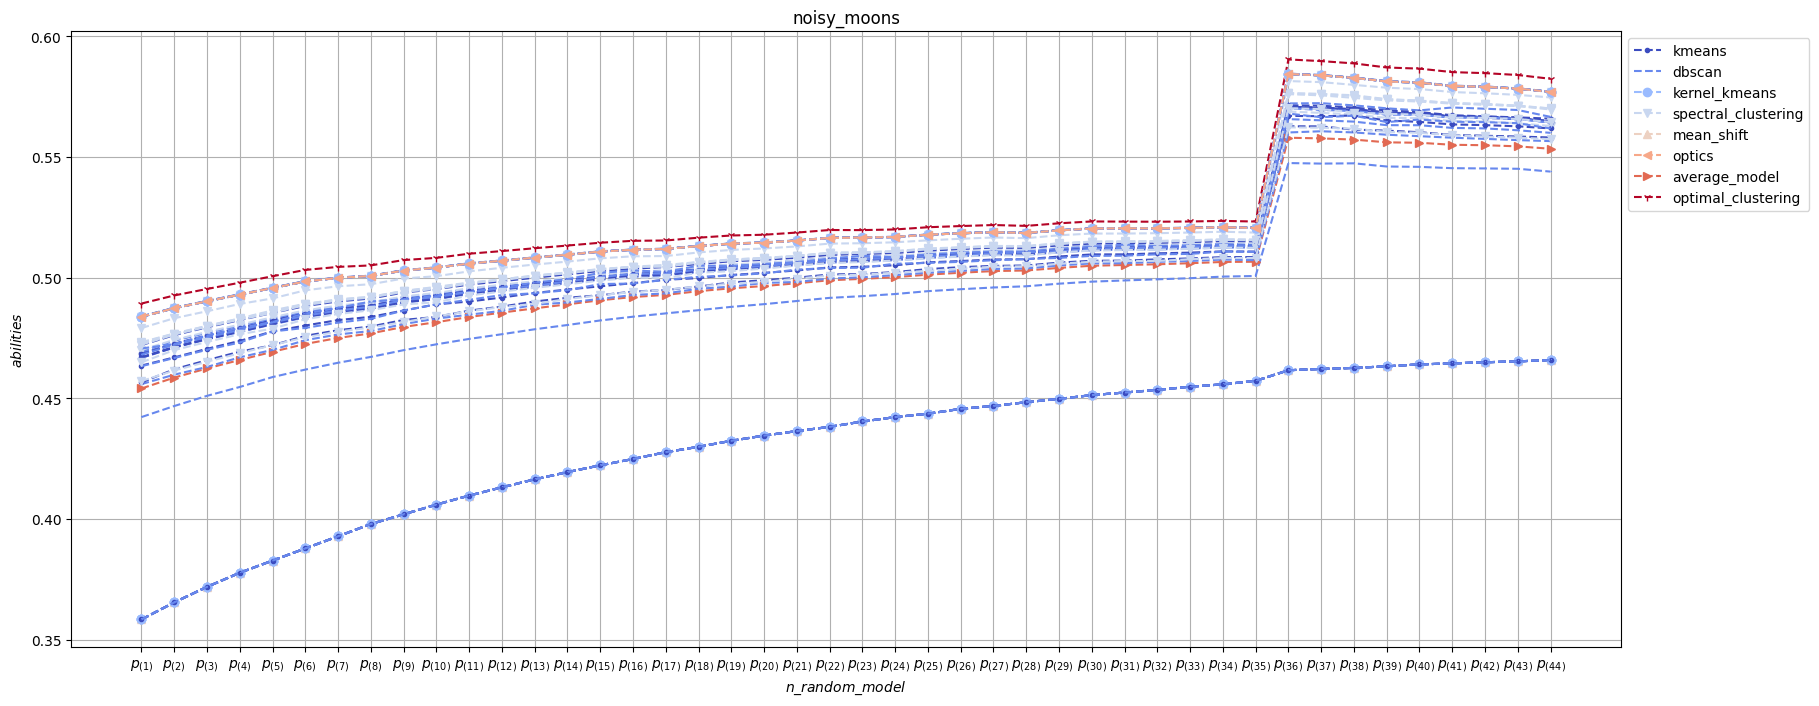

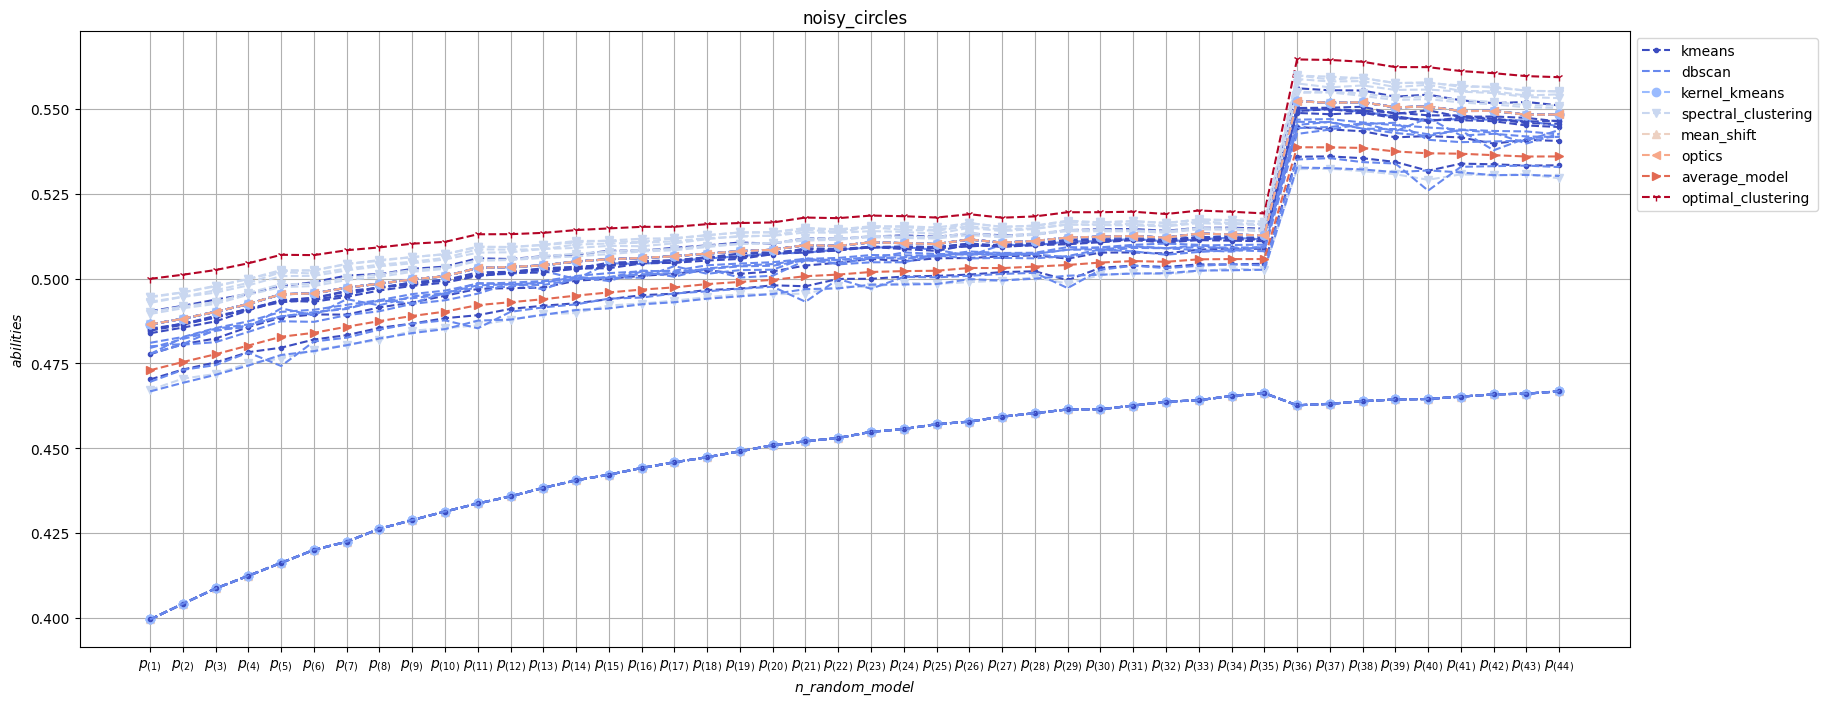

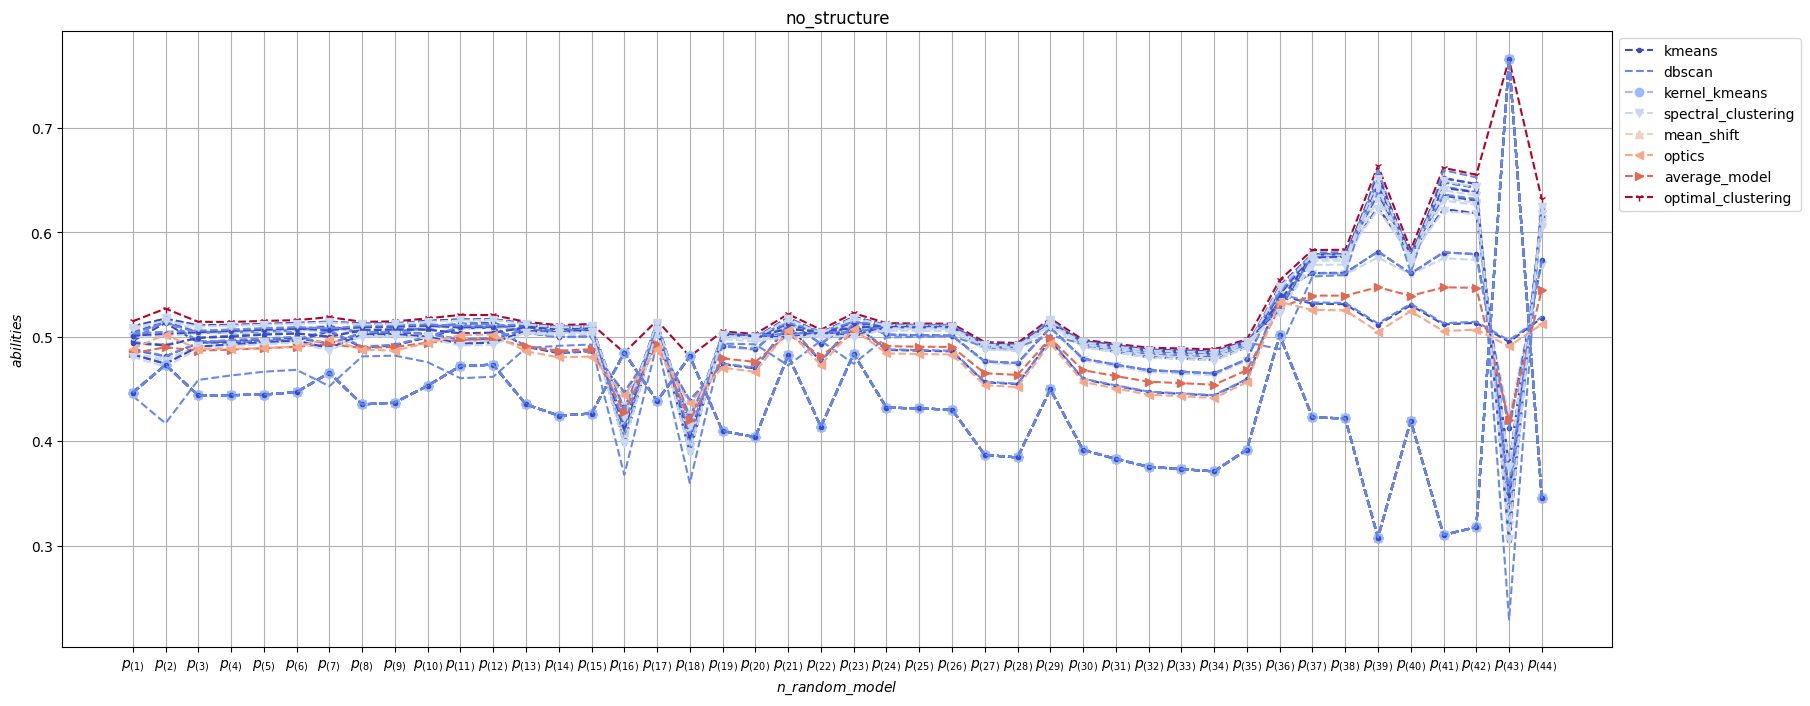

In [9]:
# by dataset
figs_dataset = {}
for name, content in datasets.items():
    _fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    content = content.dropna()
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{(" + k[1] + ")}$")
                linestyle = "--"
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")
    ax.set_xlabel(r"$n\_random\_model$")
    ax.legend(handler_lines, models, loc="upper left", bbox_to_anchor=(1.00, 1.0))
    figs_dataset[name] = _fig
    plt.ioff()

In [10]:
# global plot
fig, axes = plt.subplots(len(datasets.keys()), 1, figsize=(20, 8 * len(datasets)))

if not isinstance(axes, np.ndarray):
    axes = [axes]

for ax, (name, content) in zip(axes, datasets.items()):
    content = content.dropna()
    for line_name, line_data in content.iterrows():
        for idx, i in enumerate(models):
            if i in line_name:
                _line_index = []
                for k in line_data.index.str.split("n"):
                    _line_index.append("$p_{(" + k[1] + ")}$")
                linestyle = "--"
                ax.plot(_line_index, line_data, **_params[i])
                _line_index = []
    ax.grid(True)
    ax.set_title(name)
    ax.set_ylabel("$abilities$")

axes[-1].set_xlabel(r"$n\_random\_model$")
handler_lines = [
    Line2D([], [], color=param["color"], linestyle=param["linestyle"], marker=param["marker"])
    for param in _params.values()
]
axes[0].legend(handler_lines, models, loc="upper left", bbox_to_anchor=(1.00, 1.0))
plt.ioff()

## Save

In [11]:
fig.savefig(str(file_path_simulation_plot) + ext_best_img)  # save eps format
fig.savefig(str(file_path_simulation_plot) + ext_local_img)  # save png format

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [12]:
for name, content in figs_dataset.items():
    content.savefig(str(file_path_plot_i_dataset).format(name) + ext_best_img)  # save eps format
    content.savefig(str(file_path_plot_i_dataset).format(name) + ext_local_img)  # save png format

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back